In [6]:
import numpy as np
from scipy import optimize
import os
import subprocess
from contextlib import contextmanager
import time
import matplotlib.pyplot as plt
import math

First, we'll read in the files created by the Fortran HF code. Things are a little messy thanks to the way I stored things in the past, but they are standard numpy arrays after this cell. Take note of the ordering and suggest a more agreeable choice if you've got an opinion.

In [62]:
@contextmanager
def cwd(path):
    oldpwd=os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def spin(spin):
    if(spin==1): return -0.5
    return 0.5

def make_input(params,restart):
    in_template = "../HF/in.template"
    f1 = open(in_template, 'r')
    
    int_string = "\interaction t0={t0},x0={x0},t1={t1},x1={x1},t2={t2},x2={x2},t3={t3},x3={x3},w0={w0},sig={sig},icoul=1,icm=1,j2terms=.true. / \n".format(\
    t0=params["t0"],x0=params["x0"],t1=params["t1"],x1=params["x1"],t2=params["t2"],x2=params["x2"],t3=params["t3"],x3=params["x3"],w0=params["w0"],sig=params["sig"])
    if(restart):
        io_string = "&io printwf=F,printdens=F,restartwf=T,printhpsi=T /"
    else:
        io_string = "&io printwf=T,printdens=F,restartwf=F,printhpsi=F /"
    in_out = "../HF/in"
    f2 = open(in_out, 'w')
    f1.seek(0)
    f2.write(f1.read())
    f2.write(int_string)
    f2.write(io_string)
    f2.write("\n")

    f1.close()
    f2.close()

    return

def run_HF(tag,restart):
    noNaN = 1
    neut = 0
    if(restart == 0):
        os.system("cp in results/in."+tag)
        #print(os.system("../HF/./main"))
        output = subprocess.run(["./main"], capture_output=True)
        #print(output)
        #print(subprocess.run("../HF/./main",shell=True))
        os.system("mv out results/out."+tag)
        os.system("mv wf_numpy.bin results/wf_numpy.bin."+tag)
        noNaN = os.system("grep -q NaN results/out."+tag)
        neut = os.system('grep -q "Total Neutrons =   28.000" results/out.'+tag)
        neut = neut+os.system('grep -q "Total Neutrons =   27.999" results/out.'+tag)
    else:
        output = subprocess.run(["./main"], capture_output=True)
        #os.system("mv out results/out_rst."+tag)
        #os.system("mv hpsi.bin results/hpsi.bin."+tag)
        #print(output)
        #noNaN = os.system("grep -q NaN results/out_rst."+tag)
    if (noNaN == 0):
        print("NaNs in run {tag}!".format(tag=tag))
        return 1
    if(neut > 256):
        print("Wrong number of neutrons in run {tag}!".format(tag=tag))
        return 1

    return 0


def read_wfs(restartfile):
    #restartfile = '../HF/wf_numpy.bin'

    intchunk = np.dtype(np.int32).itemsize
    realchunk = np.dtype(np.float64).itemsize
    h = np.fromfile(restartfile, dtype=np.float64, count=1, offset=0)[0]
    nbox = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+0*intchunk))[0]
    lmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+1*intchunk))[0]
    nmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+2*intchunk))[0]
#     print("hbox = ", h)
#     print("nbox = ",nbox)
#     print("lmax = ",lmax)
#     print("nmax = ",nmax)

    #sortstates, sortenergies, wfr,
    sortstates = np.fromfile(restartfile, dtype=np.int32, count=nmax*3*2, offset=(realchunk+3*intchunk)).reshape(2,3,nmax)
    sortenergies = np.fromfile(restartfile, dtype=np.float64, count=nmax*2, offset=(realchunk+3*intchunk+nmax*3*2*intchunk)).reshape(2,nmax)
    wfs = np.fromfile(restartfile, dtype=np.float64, count=2*2*(lmax+1)*lmax*(nbox+1), offset=(realchunk+3*intchunk+nmax*3*2*intchunk+sortenergies.nbytes)).reshape(2,2,(lmax+1),lmax,(nbox+1))

    return h,nbox,lmax,nmax,sortstates,sortenergies,wfs

def print_wfs(restartfile,h,nbox,lmax,nmax,sortstates,sortenergies,wfs):
    with open(restartfile, 'wb') as file:
        file.write(h)
        file.write(nbox)
        file.write(lmax)
        file.write(nmax)
        file.write(sortstates.reshape((nmax*3*2,)))
        file.write(sortenergies.reshape((nmax*2,)))
        file.write(wfs.reshape((2*2*(lmax+1)*lmax*(nbox+1),)))

    return

def read_hpsi(restartfile):

    intchunk = np.dtype(np.int32).itemsize

    nbox = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(0*intchunk))[0]
    lmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(1*intchunk))[0]
    nmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(2*intchunk))[0]

    sortenergies = np.fromfile(restartfile, dtype=np.float64, count=nmax*2, offset=(3*intchunk)).reshape(2,nmax)
    hpsi = np.fromfile(restartfile, dtype=np.float64, count=2*2*(lmax+1)*lmax*(nbox+1), offset=(3*intchunk+sortenergies.nbytes)).reshape(2,2,(lmax+1),lmax,(nbox+1))

    return sortenergies,hpsi

def get_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf):
    restartfile = '../HF/wf_numpy.bin'
    print_wfs(restartfile,h,nbox,lmax,nmax,sortstates,sortenergies,wf)
    make_input(params,1)
    #with cwd('../HF/'):
    oldpwd=os.getcwd()
    os.chdir('../HF/')
    errors.append(run_HF("None",1))
    os.chdir(oldpwd)
    restartfile = '../HF/hpsi.bin'
    sortenergies,hpsi = read_hpsi(restartfile)

    return hpsi

def make_wf(coeffs,train_wfs,states,levels):
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    trial_wf = np.zeros(train_wfs[0].shape)
    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = sortstates[isospin,2,j]-1
                i_l = sortstates[isospin,1,j]
                i_n = sortstates[isospin,0,j]-1
                trial_wf[isospin,i_s,i_l,i_n,:] = trial_wf[isospin,i_s,i_l,i_n,:] \
                    + train_wfs[i][isospin,i_s,i_l,i_n,:] * coeffs[i*tot_levels + isospin*levels[0] + j]
    return trial_wf

def galerkin(coeffs,train_wfs,states,levels,params):
    
    global count
    global prev_time
    
    count += 1
    print("Iteration {}".format(count))
    print("Iteration time: {}".format(time.time() - prev_time))
    
    prev_time = time.time()
    
    results = np.zeros(coeffs.shape)
    
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    
    trial_wf = make_wf(coeffs,train_wfs,states,levels)

    hpsi = get_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf)

    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = sortstates[isospin,2,j]-1
                i_l = sortstates[isospin,1,j]
                i_n = sortstates[isospin,0,j]-1
                ele = i*tot_levels + isospin*levels[0] + j
                lam = coeffs[train_num*tot_levels + isospin*levels[0] + j]
                results[ele] = h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],hpsi[isospin,i_s,i_l,i_n,:]) \
                    - lam*h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])


    for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = sortstates[isospin,2,j]-1
            i_l = sortstates[isospin,1,j]
            i_n = sortstates[isospin,0,j]-1
            ele = train_num*tot_levels + isospin*levels[0] + j
            results[ele] = h*np.dot(trial_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:]) - 1.0
            
    return results

def compute_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf):
    mesh = np.linspace(0, 20, nbox+1)
    mesh[0] = 1e-25
    t0 = params["t0"]
    t1 = params["t1"]
    t2 = params["t2"]
    t3 = params["t3"]
    x0 = params["x0"]
    x1 = params["x1"]
    x2 = params["x2"]
    x3 = params["x3"]
    w0 = params["w0"]
    sig = params["sig"]
    sig = 1.0/sig
    e2 = 1.4399784
    hbar = 6.582119e-22
    hbar22m=20.73553
    A = 48.0
    cmcorr = 1.0 - (1.0/A)
    a0r0 = 3.0/8.0 * t0
    a1r1 = - 1.0/4.0 * t0 * ( 1.0/2.0 + x0 )
    a0s0 = - 1.0/4.0 * t0 * ( 1.0/2.0 - x0 )
    a1s1 = - 1.0/8.0 * t0
    
    a0tau0 = 3.0/16.0 * t1 + 1.0/4.0 * t2 * ( 5.0/4.0 + x2 )
    a1tau1 = - 1.0/8.0 * t1 * ( 1.0/2.0 + x1 ) + \
            1.0/8.0 * t2 * ( 1.0/2.0 + x2 )
    
    a0t0 = - 1.0/8.0 *t1* ( 1.0/2.0 - x1 ) + \
            1.0/8.0 * t2 * ( 1.0/2.0 + x2 )
    a1t1 =  1.0/16.0 * (t2-t1)
    
    a0r0p = - 9.0/64.0 * t1 + 1.0/16.0 * t2 *( 5.0/4.0 + x2 )
    a1r1p = 3.0/32.0 * t1 * ( 1.0/2.0 + x1 ) + \
            1.0/32.0 * t2 * ( 1.0/2.0 + x2 )

    a0s0p = 3.0/32.0 * t1 * ( 1.0/2.0 - x1 ) + \
            1.0/32.0 * t2 * ( 1.0/2.0 + x2 )
    a1s1p = 3.0/64.0 * t1 + 1.0/64.0 * t2
    
    cddr0 =  t3 / 16.00
    cddr1 = - 1.0/24.0 * t3 * ( 1.0/2.0 + x3 )
    cdds0 = - 1.0/24.0 * t3 * ( 1.0/2.0 - x3 )
    cdds1 = - 1.0/48.0 * t3
    
    cso0 = - 3.0/4.0 * w0
    cso1 = - 1.0/4.0 * w0
    rho = np.zeros((nbox+1,4))
    tau = np.zeros((nbox+1,4))
    jsc = np.zeros((nbox+1,4))
    for iq in range(2):

        rho[:,iq]=1e-25
        tau[:,iq]=1e-25
        jsc[:,iq]=1e-25
        for i in range(nmax):
            if(sortstates[iq,2,i]<1):continue
            if (sortenergies[iq,i] < - 1e-25):
                n = sortstates[iq,0,i]-1
                l = sortstates[iq,1,i]
                s = sortstates[iq,2,i]-1
                j = sortstates[iq,1,i] + spin(sortstates[iq,2,i])
                if (sortstates[iq,1,i] == 0): j = 0.5
                #print(iq,s,l,n)
                dwf = derivative_sca(wf[iq,s,l,n,:],nbox,l)
                for ir in range(1,nbox):
                    tau[ir,iq] = tau[ir,iq] + (2*j+1)*((dwf[ir]\
                    -wf[iq,s,l,n,ir]/mesh[ir])**2+l*(l+1)*(wf[iq,s,l,n,ir]**2)\
                     /mesh[ir]**2)/(4*math.pi*mesh[ir]**2)

                    rho[ir,iq] = rho[ir,iq] + (2*j+1)*wf[iq,s,l,n,ir]\
                    *wf[iq,s,l,n,ir] / (4*math.pi*mesh[ir]**2)

                    jsc[ir,iq] = jsc[ir,iq] + (2*j+1)*(j*(j+1)-l*(l+1)-0.75)\
                    *wf[iq,s,l,n,ir]**2/(4*math.pi*mesh[ir]**3)
                rho[0,iq] = rho[1,iq]
                tau[1,iq] = tau[2,iq]
                tau[0,iq] = tau[1,iq]


    rho[:,2]=rho[:,0] + rho[:,1]
    rho[0,2] = rho[1,2]
    rho[:,3]=rho[:,0] - rho[:,1]
    tau[:,2]=tau[:,0] + tau[:,1]
    tau[:,3]=tau[:,0] - tau[:,1]
    jsc[:,2]=jsc[:,0] + jsc[:,1]
    jsc[:,3]=jsc[:,0] - jsc[:,1]

    djsc = np.zeros(jsc.shape)
    drho = np.zeros(rho.shape)
    ddrho = np.zeros(rho.shape)
    laprho = np.zeros(rho.shape)

    for iq in range(2):
        for ir in range(nbox+1):
            if(ir < 1):
                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 +8*jsc[ir+1,iq] - jsc[ir+2,iq])/(12*h)

                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir+1,iq] + rho[ir+2,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir+1,iq]-rho[ir+2,iq])/(12*h**2)
            elif (ir < 2):
                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 +8*jsc[ir-1,iq] - jsc[ir,iq])/(12*h)

                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir-1,iq] + rho[ir,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir-1,iq]-rho[ir,iq])/(12*h**2)
            elif ((ir >= 2) and (ir <= nbox-2)):
                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir-1,iq] + rho[ir-2,iq])/(12*h)

                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 -8*jsc[ir-1,iq] + jsc[ir-2,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir-1,iq]-rho[ir-2,iq])/(12*h**2)
            elif ((ir > nbox-2) and (ir!=nbox)):
                drho[ir,iq] = 0.
                ddrho[ir,iq] = 0.
                djsc[ir,iq] = 0.
            else:
                drho[ir,iq] = 0.
                ddrho[ir,iq] = 0.
                djsc[ir,iq] = 0.
        ddrho[0:3,iq]=ddrho[4,iq]

    drho[:,2] = drho[:,0] + drho[:,1]
    drho[:,3] = drho[:,0] - drho[:,1]
    djsc[:,2] = djsc[:,0] + djsc[:,1]
    djsc[:,3] = djsc[:,0] - djsc[:,1]
    ddrho[:,2] = ddrho[:,0] + ddrho[:,1]
    ddrho[:,3] = ddrho[:,0] - ddrho[:,1]
    for i in range(4):
        laprho[:,i] = ddrho[:,i] + 2./mesh[:]*drho[:,i]

    uc = np.zeros((nbox+1,2))
    ucso = np.zeros((nbox+1,2))
    umr = np.zeros((nbox+1,2))
    dumr = np.zeros((nbox+1,2))
    d2umr = np.zeros((nbox+1,2))
    udd = np.zeros((nbox+1,2))
    uso = np.zeros((nbox+1,2))
    ucoul = np.zeros((nbox+1))

    for iq in range(2):
        for ir in range(nbox+1):

            #Central Field U(r)
            uc[ir,iq] = 2*(a0r0-a1r1)*rho[ir,2] + 4*a1r1 * rho[ir,iq]  \
                           + (a0tau0-a1tau1) *tau[ir,2]+ 2 *a1tau1*tau[ir,iq] \
                           +2*( a0r0p-a1r1p )*laprho[ir,2] + 4 *a1r1p * laprho[ir,iq]
            #Part of U(r) coming from so)
            ucso[ir,iq] = (cso0-cso1 ) *(djsc[ir,2] + 2 * jsc[ir,2]/mesh[ir] ) \
                             + 2 *cso1 * ( djsc[ir,iq] + 2 * jsc[ir,iq] / mesh[ir] )
            #Mq(r) contributions
            umr[ir,iq] = hbar22m*cmcorr+(a0tau0-a1tau1)*rho[ir,2] + 2 * a1tau1*rho[ir,iq]
            dumr[ir,iq] = (a0tau0-a1tau1)*drho[ir,2] + 2 * a1tau1*drho[ir,iq]
            d2umr[ir,iq] = (a0tau0-a1tau1)*ddrho[ir,2] + 2 * a1tau1*ddrho[ir,iq]
            # t3 part of U(r)
            udd[ir,iq] = ( 2 + sig ) * (cddr0-cddr1)*rho[ir,2]**(sig+1)  \
                            +2*sig*cddr1*(rho[ir,0]**2+rho[ir,1]**2)*rho[ir,2]**(sig-1.) \
                            + 4 * cddr1 * rho[ir,iq] * rho[ir,2]**sig
            #spin-orbit part
            uso[ir,iq] = - (cso0-cso1 )*drho[ir,2]/mesh[ir] \
                             - 2 *cso1 * drho[ir,iq] / mesh[ir]
            if (True):
                uso[ir,iq] = uso[ir,iq]-(a0t0-a1t1) *jsc[ir,2] / mesh[ir] \
                             - 2 *a1t1 * jsc[ir,iq] / mesh[ir]
            #coulomb
            if (iq==1):
                tot1=0.0
                tot2=0.0
                for ir2 in range(0,ir):
                    tot1=tot1+rho[ir2,1]*(mesh[ir2]**2)

                for ir2 in range(ir+1,nbox):
                    tot2=tot2+rho[ir2,1]*mesh[ir2]
                ucoul[ir]=4.0*math.pi*e2*(tot1/mesh[ir]\
                + tot2)*h - e2*(3./math.pi)**(1./3.)*rho[ir,1]**(1./3.)
    hpsi = np.zeros(wf.shape)
    #ddwf = np.zeros(wf.shape)
    for iq in range(2):
        for s in range(2):
            for l in range(lmax):
                j = l + spin(s+1)
                if (l==0): j=0.5

                for n in range(1,lmax):
                    dwf = derivative_sca(wf[iq,s,l,n,:],nbox,l)
                    ddwf = derivative_sca(dwf[:],nbox,l)

                    hpsi[iq,s,l,n,:] = umr[:,iq]*ddwf[:]+dumr[:,iq]*dwf[:] \
                    + (-uc[:,iq] -ucso[:,iq]-udd[:,iq] \
                    -uso[:,iq]*(j*(j+1.0)- l*(l+1.0) - 0.750)\
                    -dumr[:,iq]/mesh[:] + iq*ucoul[:] - umr[:,iq]*l*(l+1.0)/mesh[:]**2) * wf[iq,s,l,n,:]

    return hpsi

def derivative_sca(wf,nbox,l):
    dwf = np.zeros(wf.shape)
    boundary_condition = 2
    h_12 = h*12.00
    h_60 = h*60.00
    sig = ( l%2 - 0.50 ) * 2
    dwf[0] = ( 8.00 * wf[1] - wf[2] + sig * wf[0] ) / h_12
    dwf[1] = ( 45.00 * ( wf[2] - wf[0] ) - 9.00 * wf[3] \
         + wf[4] - sig * wf[0] ) / h_60
    dwf[2] = ( 45.00 * ( wf[3] - wf[1] ) - 9.00 * ( wf[4] - wf[0] ) \
         + wf[5] ) / h_60
    
    if ( boundary_condition == 0 or  \
        (boundary_condition == 2 and l%2 == 0) or \
        (boundary_condition == 3 and l != 2 * ( l // 2 )) ):
        dwf[nbox-1] = ( -8.00 * wf[nbox-2] + wf[nbox-1] + wf[nbox-3] ) / h_12
        dwf[nbox-2] = ( 45.00 * ( wf[nbox-1] - wf[nbox-3] ) + 9.00 * wf[nbox-4] \
            - wf[nbox-1] - wf[nbox-5] ) / h_60
        dwf[nbox-3] = ( 45.00 * ( wf[nbox-2] - wf[nbox-4] ) \
            - 9.00 * ( wf[nbox-1] - wf[nbox-5] ) - wf[nbox-6] ) / h_60
        
    if ( boundary_condition == 1 or  \
        (boundary_condition == 2 and l%2 != 0) or \
        (boundary_condition == 3 and l == 2 * ( l // 2 )) ):
        dwf[nbox-1] = ( - 54.0 * wf[nbox-2] + 45.0 * wf[nbox-1] + 10.0 * wf[nbox-3] - wf[nbox-4] ) / h_60
        dwf[nbox-2] = ( 36.0 * wf[nbox-1] + wf[nbox-2] - 45.0 * wf[nbox-3] \
            + 9.0 * wf[nbox-4] - wf[nbox-5] ) / h_60
        dwf[nbox-3] = ( 45.0 * ( wf[nbox-2] - wf[nbox-4] ) - 8.0 * wf[nbox-1]  \
            + 9.0 * wf[nbox-5] - wf[nbox-6] ) / h_60
    
    for i in range(3,nbox-4):
       dwf[i] = ( 45.00 * ( wf[i+1] - wf[i-1] )  \
            - 9.00 * ( wf[i+2] - wf[i-2] ) \
            + wf[i+3] - wf[i-3] ) / h_60
    return dwf


The following cell defines a list of parameters (only one right now) and then loops over those parameters and runs the HF code to generate outputs and WFs.

The inputs, outputs, and WFs are copied to a results folder (this can be changed) with some tag appended to the file name. In the future we may want to change how this tag is generated.

In [21]:
# params = [[-2483.45,13757.0],\
#           [-2503.45,13757.0],\
#           [-2353.45,14757.0],\
#           [-2583.45,12757.0],\
#           [-2383.45,13457.0],]

default_params = {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0}
params = [\
          {"t0":-2263.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":12757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2523.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13257.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2523.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":14757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":14157.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2443.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13357.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
         ]

errors = []

for i in range(len(params)):
    make_input(params[i],0)
    with cwd('../HF/'):
        errors.append(run_HF(str(i),0))

make_input(default_params,0)
with cwd('../HF/'):
    errors.append(run_HF("default",0))

restartfile = '../HF/results/wf_numpy.bin.default'

h,nbox,lmax,nmax,sortstates,sortenergies,wf_default = read_wfs(restartfile)


Now we read the files back in and print the energies of the single particle states to see whats up.

In [22]:
#params = [[-2483.45],[-2485.45],[-2453.45],[-2583.45],[-1983.45],]

train_wfs = []
states = []
energies = []
levels = [0,0]
for i in range(len(params)):
    if(errors[i] == 1): continue
    restartfile = '../HF/results/wf_numpy.bin.'+str(i)
    h,nbox,lmax,nmax,sortstates_t,sortenergies,wf = read_wfs(restartfile)
    train_wfs.append(wf)
    states.append(sortstates)
    hpsi = get_hpsi(params[i],h,nbox,lmax,nmax,sortstates,sortenergies,wf)

    #Calculate energies as a test for levels
    energy = [[],[]]
    for isospin in range(2):
        occupied = 0
        for i in range(lmax):
            level = i
            i_s = sortstates[isospin,2,level]-1
            i_l = sortstates[isospin,1,level]
            i_n = sortstates[isospin,0,level]-1
            if(i_s < 0): continue
            occupied += 1
            sp_en = np.sum(-h*wf[isospin,i_s,i_l,i_n,:]*hpsi[isospin,i_s,i_l,i_n,:])
            energy[isospin].append(sp_en)
            #print("Level: {}, N: {}, L: {}, S: {}".format(level+1,i_n+1,i_l,i_s))
            #print("Energy: {}".format(energy[isospin][i]))
        levels[isospin] = occupied
    energies.append(energy)

#h,nbox,lmax,nmax,sortstates,sortenergies,wf = read_wfs()
# npart = 0
# for i in range(nmax):
#     if(sortstates[0,0,i]>0):
#         nfill = int(2*(sortstates[0,1,i]+spin(sortstates[0,2,i])) + 1)
#         if (sortstates[0,1,i] == 0): nfill = 2
#         npart += nfill
#         print(npart)

Now we can calculate the hpsi (or, G) objects from Wfs. Here I am reading in training Wfs just as a test.

In [11]:
for i in range(len(params)):
    if(errors[i] == 1): continue
    # The following is to simply read in the trial WFs during testing
    restartfile = '../HF/results/wf_numpy.bin.'+str(i)
    h,nbox,lmax,nmax,sortstates,sortenergies,wf = read_wfs(restartfile)

    # get hpsi
    hpsi = get_hpsi(params[i],h,nbox,lmax,nmax,sortstates,sortenergies,wf)

    #Calculate energies as a test for levels
    occupied = 0
    for i in range(nmax):
        isospin = 0
        level = i
        i_s = sortstates[isospin,2,level]-1
        i_l = sortstates[isospin,1,level]
        i_n = sortstates[isospin,0,level]-1
        if(i_s < 0): continue
        occupied += 1
        #print("Level: {}, N: {}, L: {}, S: {}".format(level+1,i_n+1,i_l,i_s))
        #print("Energy: {}".format(np.sum(-h*wf[isospin,i_s,i_l,i_n,:]*hpsi[isospin,i_s,i_l,i_n,:])))

#print("There are {} occupied levels!".format(occupied))

In [23]:
global count
count = 0

start_time = time.time()
global prev_time 
prev_time = time.time()

train_num = len(train_wfs)

print("Training with {} WFs, each one with {} total states".format(train_num,sum(levels)))

ak = np.zeros((train_num,sum(levels)))
lam = np.zeros((sum(levels)))
coeffs = np.zeros((train_num*sum(levels) + sum(levels)))
coeffs[0:train_num*sum(levels)] = 0.5
coeffs[train_num*sum(levels):] = 25.0
#coeffs = sol.x

test_params = {"t0":-2471.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13654.0,"x3":1.2630,"w0":125.0,"sig":6.0}
#galerkin(coeffs,wfs,states,levels,test_params)

hybr_dict = {'col_deriv': 0, 'xtol': 1.49012e-8, 'maxfev': 500, 'band': None, 'eps': None, 'factor': 100, 'diag': None}
sol = optimize.root(galerkin, coeffs, args=(train_wfs,states,levels,default_params), method='hybr', options=hybr_dict)
print(sol.x)
print(galerkin(sol.x,train_wfs,states,levels,test_params))
print("Total time took: {}".format(time.time()-start_time))

Training with 7 WFs, each one with 13 total states
Iteration 1
Iteration time: 0.0005950927734375
Iteration 2
Iteration time: 0.1794896125793457
Iteration 3
Iteration time: 0.1677560806274414
Iteration 4
Iteration time: 0.15599918365478516
Iteration 5
Iteration time: 0.1714012622833252
Iteration 6
Iteration time: 0.16984057426452637
Iteration 7
Iteration time: 0.168349027633667
Iteration 8
Iteration time: 0.14856410026550293
Iteration 9
Iteration time: 0.1636972427368164
Iteration 10
Iteration time: 0.16245651245117188
Iteration 11
Iteration time: 0.16599774360656738
Iteration 12
Iteration time: 0.16057324409484863
Iteration 13
Iteration time: 0.20190715789794922
Iteration 14
Iteration time: 0.14439892768859863
Iteration 15
Iteration time: 0.1725904941558838
Iteration 16
Iteration time: 0.1632368564605713
Iteration 17
Iteration time: 0.1970350742340088
Iteration 18
Iteration time: 0.15053486824035645
Iteration 19
Iteration time: 0.15960288047790527
Iteration 20
Iteration time: 0.167170

In [24]:
# Make the test WF with test_params
make_input(test_params,0)
with cwd('../HF/'):
    errors.append(run_HF("test",0))


In [63]:
# Make trial WF and hpsi with solved coeffs
trial_wf = make_wf(sol.x,train_wfs,states,levels)
trial_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf)

# Read in the cheated test
restartfile = '../HF/results/wf_numpy.bin.test'
h,nbox,lmax,nmax,sorts,sorte,test_wf = read_wfs(restartfile)
test_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sorts,sorte,test_wf)
test_hpsi_2 = compute_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,wf)

for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = sortstates[isospin,2,j]-1
            i_l = sortstates[isospin,1,j]
            i_n = sortstates[isospin,0,j]-1
            norm = np.dot(h*test_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            trial_sp = np.dot(-h*trial_hpsi[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            test_sp = np.dot(-h*test_hpsi[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            test_sp_2 = np.dot(-h*test_hpsi_2[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            print("Trial: {trial} Test: {test} Difference: {diff} Norm: {norm}".format(trial=trial_sp,test=test_sp,diff=(trial_sp-test_sp)/trial_sp,norm=norm))
            print("Trial: {trial} Test: {test} Difference: {diff} Norm: {norm}".format(trial=trial_sp,test=test_sp_2,diff=(trial_sp-test_sp)/trial_sp,norm=norm))



Trial: -63.689261279900194 Test: -49.90215075533472 Difference: 0.21647464968975183 Norm: 1.2761821128141042
Trial: -63.689261279900194 Test: 0.0 Difference: 0.21647464968975183 Norm: 1.2761821128141042
Trial: -61.00869716364979 Test: -35.998682823529236 Difference: 0.40994178703789835 Norm: 1.6947479767873959
Trial: -61.00869716364979 Test: 0.0 Difference: 0.40994178703789835 Norm: 1.6947479767873959
Trial: -33.58854589222827 Test: -33.929271284174746 Difference: -0.0101440947470523 Norm: 0.9899565908602586
Trial: -33.58854589222827 Test: 0.0 Difference: -0.0101440947470523 Norm: 0.9899565908602586
Trial: -33.80147200788126 Test: -22.164002717900956 Difference: 0.34428883118660847 Norm: 1.5250607153163542
Trial: -33.80147200788126 Test: 0.0 Difference: 0.34428883118660847 Norm: 1.5250607153163542
Trial: -22.474300510443413 Test: -17.784398838443437 Difference: 0.2086784267132435 Norm: 1.2646508764235047
Trial: -22.474300510443413 Test: -17.77032379345389 Difference: 0.2086784267132435

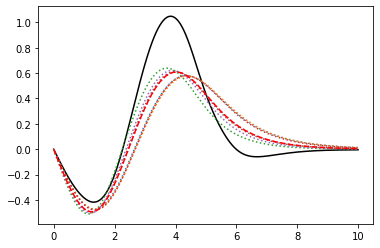

In [29]:
fig = plt.figure()
ax = plt.axes()

isospin = 0
i_s = 0
i_l = 0
i_n = 1

x = np.linspace(0, 20, 2001)
ax.plot(x[:1000],trial_wf[isospin,i_s,i_l,i_n,:1000],color='black')
for i in range(len(train_wfs)):
    ax.plot(x[:1000],train_wfs[i][isospin,i_s,i_l,i_n,:1000],linestyle=":")
ax.plot(x[:1000],test_wf[isospin,i_s,i_l,i_n,:1000],linestyle='--',color='red')